In [1]:
import sys
sys.path.append("D:\python\lib\site-packages")
import pyxdf as xdf
import numpy as np
import matplotlib.pyplot as plt
import mne
%matplotlib notebook

### Load your data from the .xdf file

In [2]:
# Load file
streams = xdf.load_xdf("test3.xdf")

# Extract streams
unitystr_time_series     = streams[0][0]['time_series'][2:]
unitystr_time_stamps     = streams[0][0]['time_stamps'][2:]
unitystr_first_timestamp = np.float(unitystr_time_stamps[0])#np.float(streams[0][0]['footer']['info']['first_timestamp'][2])

openvibemarkers_time_series     = streams[0][1]['time_series']
openvibemarkers_time_stamps     = streams[0][1]['time_stamps']
openvibemarkers_first_timestamp = np.float(streams[0][1]['footer']['info']['first_timestamp'][0])

eeg_time_series     = streams[0][2]['time_series']
eeg_time_stamps     = streams[0][2]['time_stamps']
eeg_first_timestamp = np.float(streams[0][2]['footer']['info']['first_timestamp'][0])

# Sampling frequency of the recorded eeg data
sfreq = np.float(streams[0][2]['info']['nominal_srate'][0])

In [3]:
#Convert labels to 1s
for i in range (len(unitystr_time_series)):
    unitystr_time_series[i] = 1

In [4]:
unitystr_time_series

[1, 1, 1, 1]

In [4]:
unitystr_time_stamps

array([64.13798721, 73.26789432, 81.50698555, 86.89190459])

In [5]:
eeg_time_stamps

array([ 61.62166863,  61.62948113,  61.63729363, ..., 111.25448654,
       111.26229904, 111.27011154])

### Create a RAW array object to store the EEG data

In [6]:
# 14 channels: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4

ch_names = ('AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4')

# Create the info file
info = mne.create_info(ch_names, sfreq, ch_types='eeg' )

# Convert first time to sample
first_samp = int(eeg_first_timestamp*sfreq)
print(first_samp)

7888


In [7]:
# NB set the first sample to be able to align the events
raw = mne.io.RawArray(eeg_time_series.T, info, first_samp=first_samp)

# raw.set_eeg_reference()

Creating RawArray with float64 data, n_channels=14, n_times=6356
    Range : 7888 ... 14243 =     61.625 ...   111.273 secs
Ready.


### Set montage

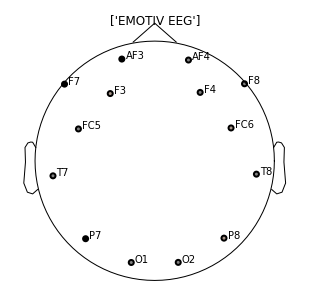

In [8]:
montage = mne.channels.read_montage('standard_1020')

raw.set_montage(montage)
f = raw.plot_sensors(ch_type='eeg', title=['EMOTIV EEG'], show_names=True, ch_groups='position', show=False)
f.set_size_inches(4,4)

Effective window size : 16.000 (s)


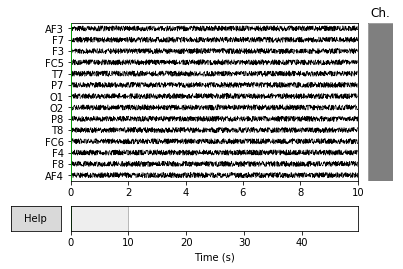

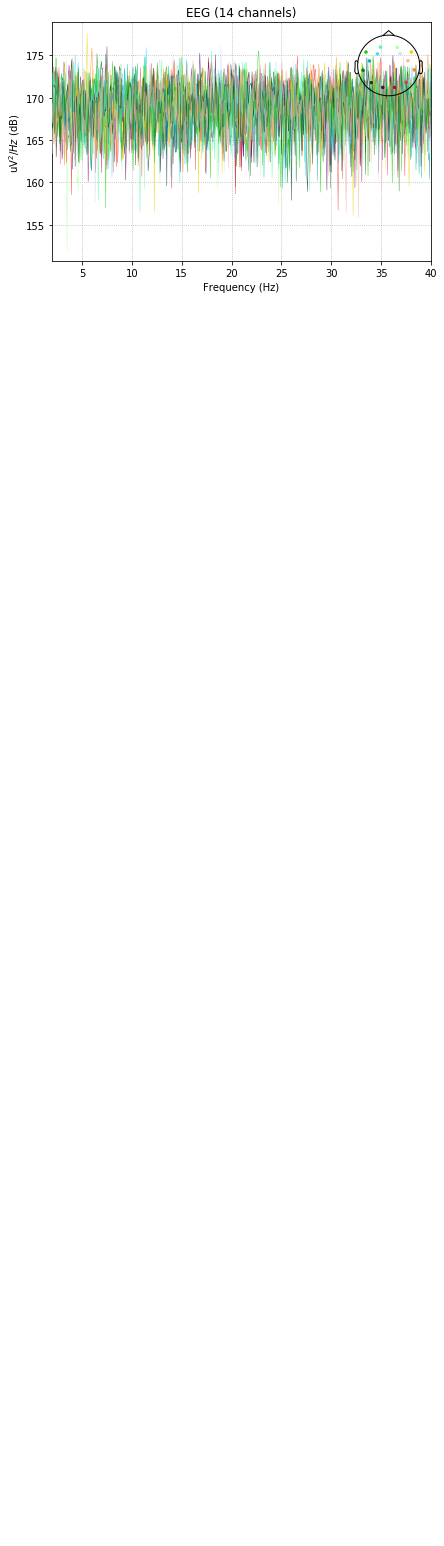

In [9]:
# Plot some data
raw.plot(scalings='auto', n_channels=14, show=False);

raw.plot_psd(fmin=2.0, fmax=40.0, show=False);

### Define the event channel

In [10]:
# Create a ne stimulation channels
info         = mne.create_info(['STI'], raw.info['sfreq'], ch_types=['stim'])
# Fill it with an vector of zeros
stim_data    = np.zeros((1, len(raw.times)))

In [11]:
stim_raw     = mne.io.RawArray(stim_data, info, first_samp=first_samp)

Creating RawArray with float64 data, n_channels=1, n_times=6356
    Range : 7888 ... 14243 =     61.625 ...   111.273 secs
Ready.


In [12]:
# Add the new channel to your dataset
raw.add_channels([stim_raw], force_update_info=False)

<RawArray  |  None, n_channels x n_times : 15 x 6356 (49.6 sec), ~787 kB, data loaded>

In [13]:
(unitystr_time_stamps*sfreq).astype('int')

array([ 8209,  9378, 10432, 11122])

In [14]:
# You need to build an array of events
events = np.array(((openvibemarkers_time_stamps*sfreq).astype('int'), np.zeros((len(openvibemarkers_time_series),)), np.squeeze(openvibemarkers_time_series)))

In [43]:
# You need to build an array of events
events = np.array(((unitystr_time_stamps*sfreq).astype('int'), np.zeros((len(unitystr_time_series),)), np.squeeze([unitystr_time_series])))

In [44]:
print(events)

[[8.2090e+03 9.3780e+03 1.0432e+04 1.1122e+04]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00]]


In [45]:
# Add the openvibe events
raw.add_events(events.T, stim_channel='STI')

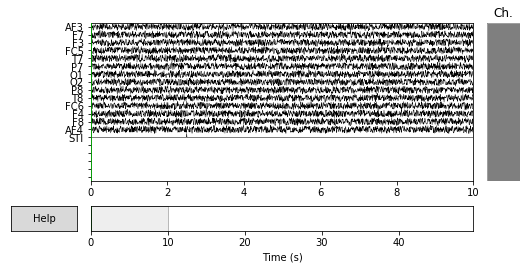

In [50]:
f = raw.plot(scalings='auto', show=False)
f.set_size_inches(8,4)

In [51]:
### Re-reference your data
raw.set_eeg_reference()

Applying average reference.
Applying a custom EEG reference.


<RawArray  |  None, n_channels x n_times : 15 x 6356 (49.6 sec), ~787 kB, data loaded>

### Epoching data

In [52]:
## evs should return the same 'events' array you used to create the channel ( I did it just to confirm that all the events are there)


# With the option output='onset' we find only 26 events NB EVENTS ARE VERY CLOSE (JUST 1 TIMESTAMP BETWEEN TWO EVENTS)
# If you set it to 'step' you will have back all the 52 events (but it does not make sense for epoching your data)



evs = mne.find_events(raw, stim_channel='STI', output='onset', shortest_event=1,
                         min_duration=1/raw.info['sfreq'])
print('Number of events found: %d' % len(evs))

4 events found
Event IDs: [2]
Number of events found: 4


In [53]:
# Pick the channels you want to include 
reject = dict(eeg=150e-6) # you can set a rejection threshold for bad data (NB in this case all data will be discarded)

baseline = (None,None)
picks = mne.pick_types(raw.info, meg=False, eeg=True, ecg=False, eog=False, stim=False, exclude=[])


# Define the beginning and the end of each epoch
tmin = -1.
tmax = 2.5

# Epoch the data around event 1 (here defined as "trial_start")
epochs =  mne.Epochs(raw, evs, tmin=tmin, tmax=tmax, 
                     baseline=baseline, preload=True, reject=None)

# Check if all the epochs (nr of trials in the experiment) were extracted
print('Number of epochs: %d' % len(epochs))

4 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 4 events and 449 original time points ...
0 bad epochs dropped
Number of epochs: 4


In [56]:
epochs.events

array([[ 8209,     0,     2],
       [ 9378,     0,     2],
       [10432,     0,     2],
       [11122,     0,     2]])

In [ ]:
#mne extract power; take windows of 100ms and average the values of these (windowlength and overlapping of the time windows is up to us)or 500ms and moving of 200, etc normally overlapping is 80%. it will be a vector of all the freq values of this timeframe and those can be fed to the network. he suggests recurrent network. make it parametric so we can modify variables. important to put labels